## 1. Setup Environment

In [1]:
# Check if running in Colab
import sys

# Check GPU availability
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: Tesla T4


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set project path in Drive
PROJECT_PATH = "/content/drive/MyDrive/ML_Sentiment_Analysis"


Mounted at /content/drive


In [3]:
# Install required packages
!pip install -q nlpaug transformers sentencepiece spacy pandas tqdm

# Download spaCy Romanian model
!python -m spacy download ro_core_news_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 31.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Clone/setup project (if in Colab and not already present)
import os

# Option 1: Clone from GitHub (uncomment if using git)
!git clone https://github.com/R3dP4ndaXD/sentiment_analysis.git
%cd sentiment_analysis

# Option 2: Use project from Drive
# %cd {PROJECT_PATH}

# Verify project structure
!ls -la

Cloning into 'sentiment_analysis'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 213 (delta 118), reused 160 (delta 65), pack-reused 0 (from 0)
Receiving objects: 100% (213/213), 1.05 MiB | 4.32 MiB/s, done.
Resolving deltas: 100% (118/118), done.
/content/sentiment_analysis
total 48
drwxr-xr-x 8 root root 4096 Jan 10 09:24 .
drwxr-xr-x 1 root root 4096 Jan 10 09:24 ..
-rw-r--r-- 1 root root 6714 Jan 10 09:24 cerinta.md
drwxr-xr-x 3 root root 4096 Jan 10 09:24 data
drwxr-xr-x 8 root root 4096 Jan 10 09:24 .git
drwxr-xr-x 2 root root 4096 Jan 10 09:24 .github
-rw-r--r-- 1 root root  593 Jan 10 09:24 .gitignore
drwxr-xr-x 2 root root 4096 Jan 10 09:24 notebooks
-rw-r--r-- 1 root root  202 Jan 10 09:24 requirements.txt
drwxr-xr-x 9 root root 4096 Jan 10 09:24 results
drwxr-xr-x 8 root root 4096 Jan 10 09:24 src


In [5]:
# Add project to Python path
import sys
sys.path.insert(0, '.')

# Verify imports work
from src.data.augmentations import back_translate, contextual_word_replacement
from src.preprocessing.text import tokenize, detokenize
print("✓ Imports successful")

✓ Imports successful


## Download Dataset

In [6]:
import os
import pandas as pd

# Create data directories
os.makedirs('data/raw', exist_ok=True)
os.makedirs('data/processed', exist_ok=True)

# Download ro_sent dataset
TRAIN_URL = "https://raw.githubusercontent.com/dumitrescustefan/Romanian-Transformers/examples/examples/sentiment_analysis/ro/train.csv"
TEST_URL = "https://raw.githubusercontent.com/dumitrescustefan/Romanian-Transformers/examples/examples/sentiment_analysis/ro/test.csv"

!wget -q -O data/raw/train.csv "{TRAIN_URL}" 2>/dev/null || echo "Downloading train.csv..."
!wget -q -O data/raw/test.csv "{TEST_URL}" 2>/dev/null || echo "Downloading test.csv..."

# Check if download succeeded, if not try alternative method
if not os.path.exists('data/raw/train.csv') or os.path.getsize('data/raw/train.csv') < 1000:
    print("Trying alternative download method...")
    # Use datasets library as fallback
    !pip install -q datasets
    from datasets import load_dataset
    dataset = load_dataset("dumitrescustefan/ro_sent")
    dataset['train'].to_pandas().to_csv('data/raw/train.csv', index=False)
    dataset['test'].to_pandas().to_csv('data/raw/test.csv', index=False)

# Verify download
train_df = pd.read_csv('data/raw/train.csv')
test_df = pd.read_csv('data/raw/test.csv')
print(f"✅ Train samples: {len(train_df)}")
print(f"✅ Test samples: {len(test_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nLabel distribution (train):")
print(train_df['label'].value_counts())

✅ Train samples: 17941
✅ Test samples: 11005

Columns: ['index', 'text', 'label']

Label distribution (train):
label
1    11094
0     6847
Name: count, dtype: int64


In [7]:
# Create train/val/test split
from sklearn.model_selection import train_test_split

# Split train into train/val (85/15)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.15,
    random_state=42,
    stratify=train_df['label']
)

# Save processed splits
DATA_DIR = "data/processed"
train_data.to_csv('data/processed/train.csv', index=False)
val_data.to_csv('data/processed/val.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

print(f"✅ Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_df)}")

✅ Train: 15249 | Val: 2692 | Test: 11005


## 2. Explore Dataset

In [8]:
import pandas as pd

# Load training data
train_df = pd.read_csv("data/processed/train.csv")
print(f"Training samples: {len(train_df)}")

# Class distribution
class_counts = train_df['label'].value_counts()
print(f"\nClass distribution:")
for label, count in class_counts.items():
    pct = count / len(train_df) * 100
    sentiment = "Positive" if label == 1 else "Negative"
    print(f"  {sentiment} (label={label}): {count} ({pct:.1f}%)")

# Calculate imbalance
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

Training samples: 15249

Class distribution:
  Positive (label=1): 9429 (61.8%)
  Negative (label=0): 5820 (38.2%)

Imbalance ratio: 1.62:1


In [19]:
# Sample texts from each class
print("Sample NEGATIVE reviews:")
for text in train_df[train_df['label'] == 0]['text'].head(3):
    print(f"  • {text[:100]}...")

print("\nSample POSITIVE reviews:")
for text in train_df[train_df['label'] == 1]['text'].head(3):
    print(f"  • {text[:100]}...")

Sample NEGATIVE reviews:
  • micul oras californian diablo este afectat de decese misterioase dupa ce seriful robert lopez descop...
  • un alt "fiu care nu va creste" si doar celelalte recente asemanatoare. heder intr-o alta peruca proa...
  • acest lucru trebuie sa fie insotit de o nota speciala si un avertisment: nu este recomandat persoane...

Sample POSITIVE reviews:
  • asta e corect. filmul este mai bun decat cartea. nu ma intelegeti rau, imi place cartea. dar filmul ...
  • boxa ideala
super ok....
  • eu cred ca in cinematografie, scopul principal in ceea ce-l priveste pe spectator, este impresia, a ...


## 3. Test Augmentation Functions

In [20]:
# Test back-translation (this will download M2M100 model ~2GB on first run)
test_text = "Produsul este foarte bun, recomand cu încredere!"
tokens = tokenize(test_text)

print(f"Original: {test_text}")
print(f"Tokens: {tokens}")

# This may take a minute on first run (model download)
print("\nTesting back-translation (may take a minute on first run)...")
aug_tokens = back_translate(tokens, device=DEVICE)
aug_text = detokenize(aug_tokens)
print(f"Back-translated: {aug_text}")

Original: Produsul este foarte bun, recomand cu încredere!
Tokens: ['produsul', 'este', 'foarte', 'bun', 'recomand', 'cu', 'încredere']

Testing back-translation (may take a minute on first run)...
Back-translated: Produsul este foarte bun, recomand cu încredere.


In [21]:
# Test contextual word replacement
print(f"Original: {test_text}")
print("\nTesting contextual word replacement...")
aug_tokens = contextual_word_replacement(tokens, n_replacements=2, device=DEVICE)
aug_text = detokenize(aug_tokens)
print(f"Contextual replace: {aug_text}")

Original: Produsul este foarte bun, recomand cu încredere!

Testing contextual word replacement...


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/500M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.output.dense.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, cls.predictions.bias, cls.predictions.transform.dense.weight, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.output.LayerNorm.weight, cls.predictions.transform.dense.bias, cls.predictions.transform.LayerNorm.bias, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.self.query.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.LayerNorm.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.intermediate.d

Contextual replace: produsul este foarte bun tratat cu caldura


## 4. Run Offline Augmentation

Choose your augmentation strategy:

| Strategy | Speed | Quality | Use Case |
|----------|-------|---------|----------|
| `back_translate` | Slow | High | Best paraphrasing |
| `contextual_replace` | Medium | High | Semantic variation |
| `synonym` | Fast | Medium | Simple word replacement |
| `swap` + `delete` | Very Fast | Low | Structural noise |

In [38]:
# Configuration
AUGMENTATION_CONFIG = {
    "input": "data/processed/train.csv",
    "output": "data/augmented/train.csv",
    "augment": ["back_translate"],   # Options: back_translate, contextual_replace, contextual_insert
    "balance": False,                 # Balance classes
    "augment_per_sample": 0.1,
    "minority_only": False,           # Only augment minority class
    "device": DEVICE,
    "seed": 42,
}

print("Augmentation Configuration:")
for k, v in AUGMENTATION_CONFIG.items():
    print(f"  {k}: {v}")

Augmentation Configuration:
  input: data/processed/train.csv
  output: data/augmented/train.csv
  augment: ['back_translate']
  balance: False
  augment_per_sample: 0.1
  minority_only: False
  device: cuda
  seed: 42


In [15]:
# Build command
cmd = f"""python -m src.data.offline_augmentation \
    --input {AUGMENTATION_CONFIG['input']} \
    --output {AUGMENTATION_CONFIG['output']} \
    --augment {' '.join(AUGMENTATION_CONFIG['augment'])} \
    --device {AUGMENTATION_CONFIG['device']} \
    --seed {AUGMENTATION_CONFIG['seed']}"""

if AUGMENTATION_CONFIG['balance']:
    cmd += f" --balance --target_ratio {AUGMENTATION_CONFIG['target_ratio']}"

if AUGMENTATION_CONFIG.get('minority_only'):
    cmd += " --minority_only"

if AUGMENTATION_CONFIG.get('augment_per_sample'):
    cmd += f" --augment_per_sample {AUGMENTATION_CONFIG['augment_per_sample']}"

print("Command to run:")
print(cmd)

Command to run:
python -m src.data.offline_augmentation     --input data/processed/train.csv     --output data/augmented/train_balanced.csv     --augment back_translate     --device cuda     --seed 42 --augment_per_sample 0.1


In [16]:
# Run augmentation (this may take 30-60 minutes depending on dataset size and GPU)
!{cmd}

2026-01-10 09:29:25.391975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768037365.411898    2456 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768037365.417931    2456 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768037365.432890    2456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768037365.432916    2456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768037365.432919    2456 computation_placer.cc:177] computation placer alr

## 5. Verify Results

In [17]:
# Load augmented dataset
output_path = AUGMENTATION_CONFIG['output']
aug_df = pd.read_csv(output_path)

print(f"Augmented dataset: {len(aug_df)} samples")
print(f"Original dataset: {len(train_df)} samples")
print(f"Expansion: {len(aug_df) / len(train_df):.2f}x")

Augmented dataset: 16504 samples
Original dataset: 15249 samples
Expansion: 1.08x


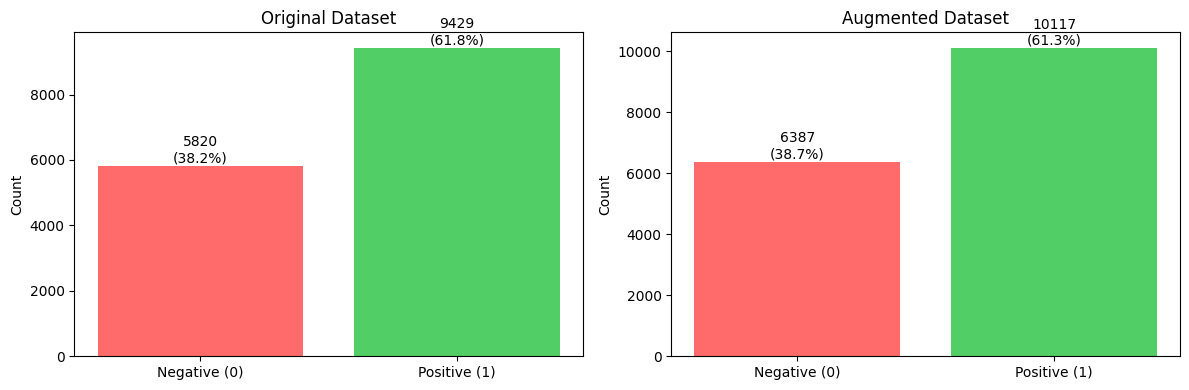


Imbalance ratio:
  Original: 1.62:1
  Augmented: 1.58:1


In [23]:
# Class distribution comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original
orig_counts = train_df['label'].value_counts().sort_index()
axes[0].bar(['Negative (0)', 'Positive (1)'], orig_counts.values, color=['#ff6b6b', '#51cf66'])
axes[0].set_title('Original Dataset')
axes[0].set_ylabel('Count')
for i, v in enumerate(orig_counts.values):
    axes[0].text(i, v + 100, f'{v}\n({v/len(train_df)*100:.1f}%)', ha='center')

# Augmented
aug_counts = aug_df['label'].value_counts().sort_index()
axes[1].bar(['Negative (0)', 'Positive (1)'], aug_counts.values, color=['#ff6b6b', '#51cf66'])
axes[1].set_title('Augmented Dataset')
axes[1].set_ylabel('Count')
for i, v in enumerate(aug_counts.values):
    axes[1].text(i, v + 100, f'{v}\n({v/len(aug_df)*100:.1f}%)', ha='center')

plt.tight_layout()
plt.savefig('plots/augmentation_balance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nImbalance ratio:")
print(f"  Original: {orig_counts.max()/orig_counts.min():.2f}:1")
print(f"  Augmented: {aug_counts.max()/aug_counts.min():.2f}:1")

Samples by type:
augmented  False  True 
label                  
0           5806    581
1           9197    920


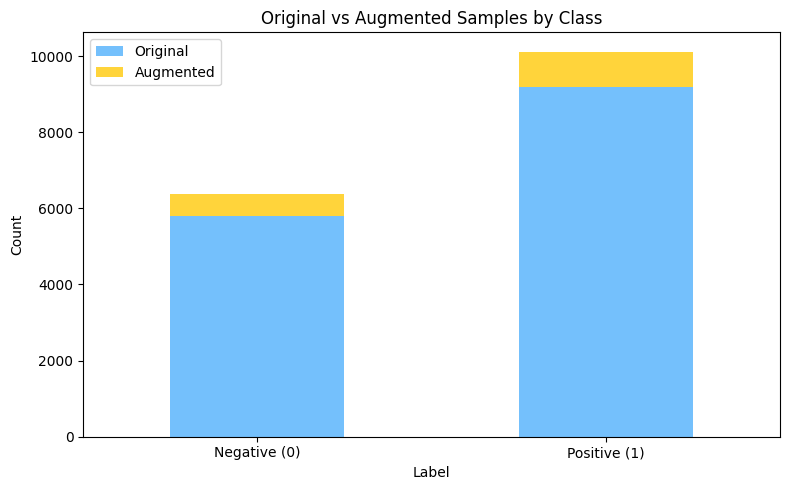

In [24]:
# Show augmented vs original breakdown
if 'augmented' in aug_df.columns:
    aug_breakdown = aug_df.groupby(['label', 'augmented']).size().unstack(fill_value=0)
    print("Samples by type:")
    print(aug_breakdown)

    # Visualize
    aug_breakdown.plot(kind='bar', stacked=True, figsize=(8, 5),
                       color=['#74c0fc', '#ffd43b'])
    plt.title('Original vs Augmented Samples by Class')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.legend(['Original', 'Augmented'])
    plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'], rotation=0)
    plt.tight_layout()
    plt.savefig('plots/augmentation_breakdown.png', dpi=150, bbox_inches='tight')
    plt.show()

In [25]:
# Sample augmented texts
print("Sample AUGMENTED texts (minority class):")
print("="*60)

minority_label = train_df['label'].value_counts().idxmin()
augmented_samples = aug_df[(aug_df['label'] == minority_label) & (aug_df.get('augmented', False) == True)]

for i, row in augmented_samples.head(5).iterrows():
    print(f"\n[{row.get('aug_type', 'augmented')}]")
    print(f"  {row['text'][:150]}..." if len(row['text']) > 150 else f"  {row['text']}")

Sample AUGMENTED texts (minority class):

[back_translate]
  Filmul a fost bine nu rău nu sunt bine doar bine dacă a existat altceva în teatru acest lucru ar fi lipsit departe de, din păcate, rapid și furioasă 2...

[back_translate]
  Mă întreb dacă există un sens în acest film este o glumă mare bine este distractiv trebuie să vezi cel mai stupid scenariu jucat foarte serios în form...

[back_translate]
  Vreau să încerc să mă mențin în același ton, dar dintr-o altă perspectivă mai tehnică pot lupta cu mine mai mature jucători sau cinefilii dedicate une...

[back_translate]
  1 din 10 br acest lucru este tipul de film pe care nu te poți gândi că ai pierdut doar 2 ore din viața ta, deoarece vezi rolul de credit cred sincer c...

[back_translate]
  Am dat calificarea 1 la traseu ca filmul nu l-am văzut încă și nu cred că o voi vedea ideea mea se pare chiar absurd Iron Man chiar traduce omul de oț...


## 6. Copy to Drive (Optional)

In [40]:
# If running locally, copy augmented data to Drive for later use

import shutil

drive_output = "/content/drive/MyDrive/ML_Sentiment_Analysis/data/augmented/"
os.makedirs(drive_output, exist_ok=True)

# Copy files
shutil.copy(output_path, drive_output)
clean_path = output_path.replace('.csv', '_clean.csv')
if os.path.exists(clean_path):
    shutil.copy(clean_path, drive_output)

print(f"✓ Copied augmented data to {drive_output}")
!ls -la {drive_output}

✓ Copied augmented data to /content/drive/MyDrive/ML_Sentiment_Analysis/data/augmented/
total 14724
-rw------- 1 root root 7410870 Jan 10 13:30 train_balanced_clean.csv
-rw------- 1 root root 7665954 Jan 10 13:30 train_balanced.csv


## 7. Next Steps

Now you can train your model on the augmented dataset:

```bash
# Use the augmented data directory
python -m src.run_experiment \
    --model bilstm \
    --data_dir data/augmented \
    --epochs 20 \
    --device cuda
```

**Note:** When using pre-augmented data:
- DON'T use `--balance_classes` (already balanced)
- DON'T use `--expand_factor` (already expanded)
- You CAN still use light online augmentation (`--augment eda`) for variety